In [ ]:
import os
import subprocess
import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


## Models

Time series can be either univariate or multivariate:

>**Univariate** time series only has a single time-dependent variable.

>**Multivariate** time series have a multiple time-dependent variable.

Our example originally is a multivariate time series because its has multiple features that are all time-dependent.


We will evaluate the Mean Absolute Error (MAE) and the Root Mean Square Error (RMSE) of the models. For metrics are better the smaller they are.

> Since our data has multiple features we are going to use multivariate or dependent multi-series forecasting methods

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiSeriesCustom import ForecasterAutoregMultiSeriesCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# clean_METData = pd.read_csv('../content/drive/My Drive/Colab Notebooks/Drought/clean_METData.csv')
data = clean_METData[['date','T2M_RANGE','T2M_MIN','WS10M_MAX','PRECTOTCORR','SPI']]
data.head()

,date,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
0,1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1,1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
2,1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
3,1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
4,1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Data preparation
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('7D')
data = data.sort_index()
data.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
date,,,,,
1991-01-29,-257.431429,14.625429,8.362857,0.530000,0.644588
1991-02-05,-257.098571,14.680000,8.398000,0.329714,0.551844
1991-02-12,-257.569143,15.220286,8.444000,0.428857,0.554402
1991-02-19,-258.402286,16.105714,8.074857,0.562857,0.778456
1991-02-26,-257.958571,15.976857,8.043429,0.442571,0.649131


In [ ]:
# Split data into train-val-test
# ==============================================================================
end_train = '2020-01-01 '
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 1991-01-29 00:00:00 --- 2019-12-31 00:00:00   (n=1510)
Test dates  : 2020-01-07 00:00:00 --- 2023-03-28 00:00:00   (n=169)


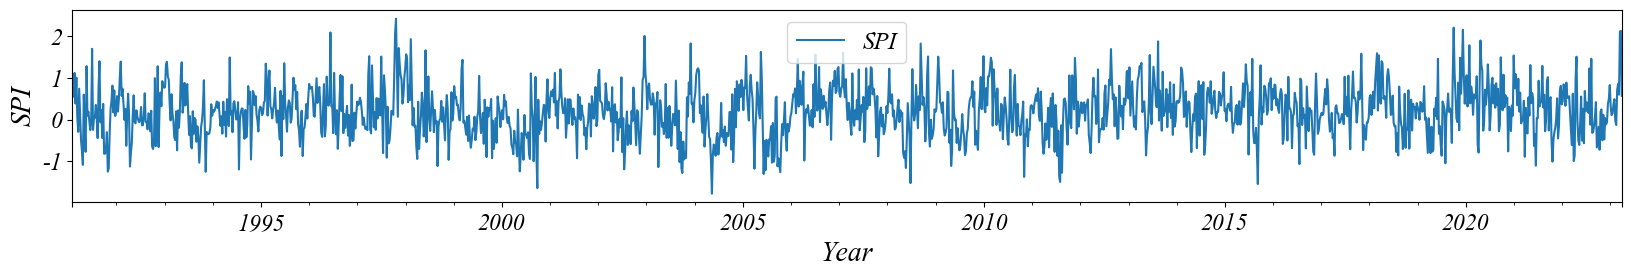

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
rdata['SPI'].plot(ax=ax)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2 )
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17)

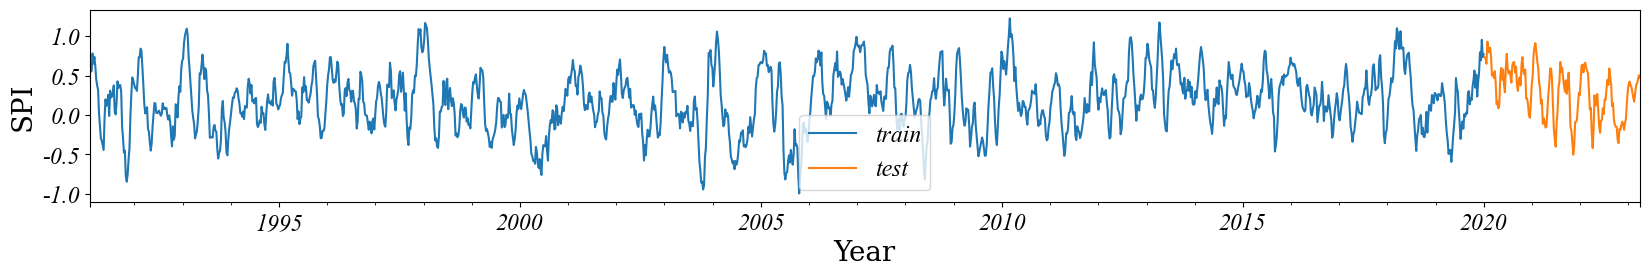

In [ ]:
# Plot
# ==============================================================================
#define font family to use for all text
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['font.family'] = 'Times New Roman'

font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.rcParams['axes.unicode_minus'] = False
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

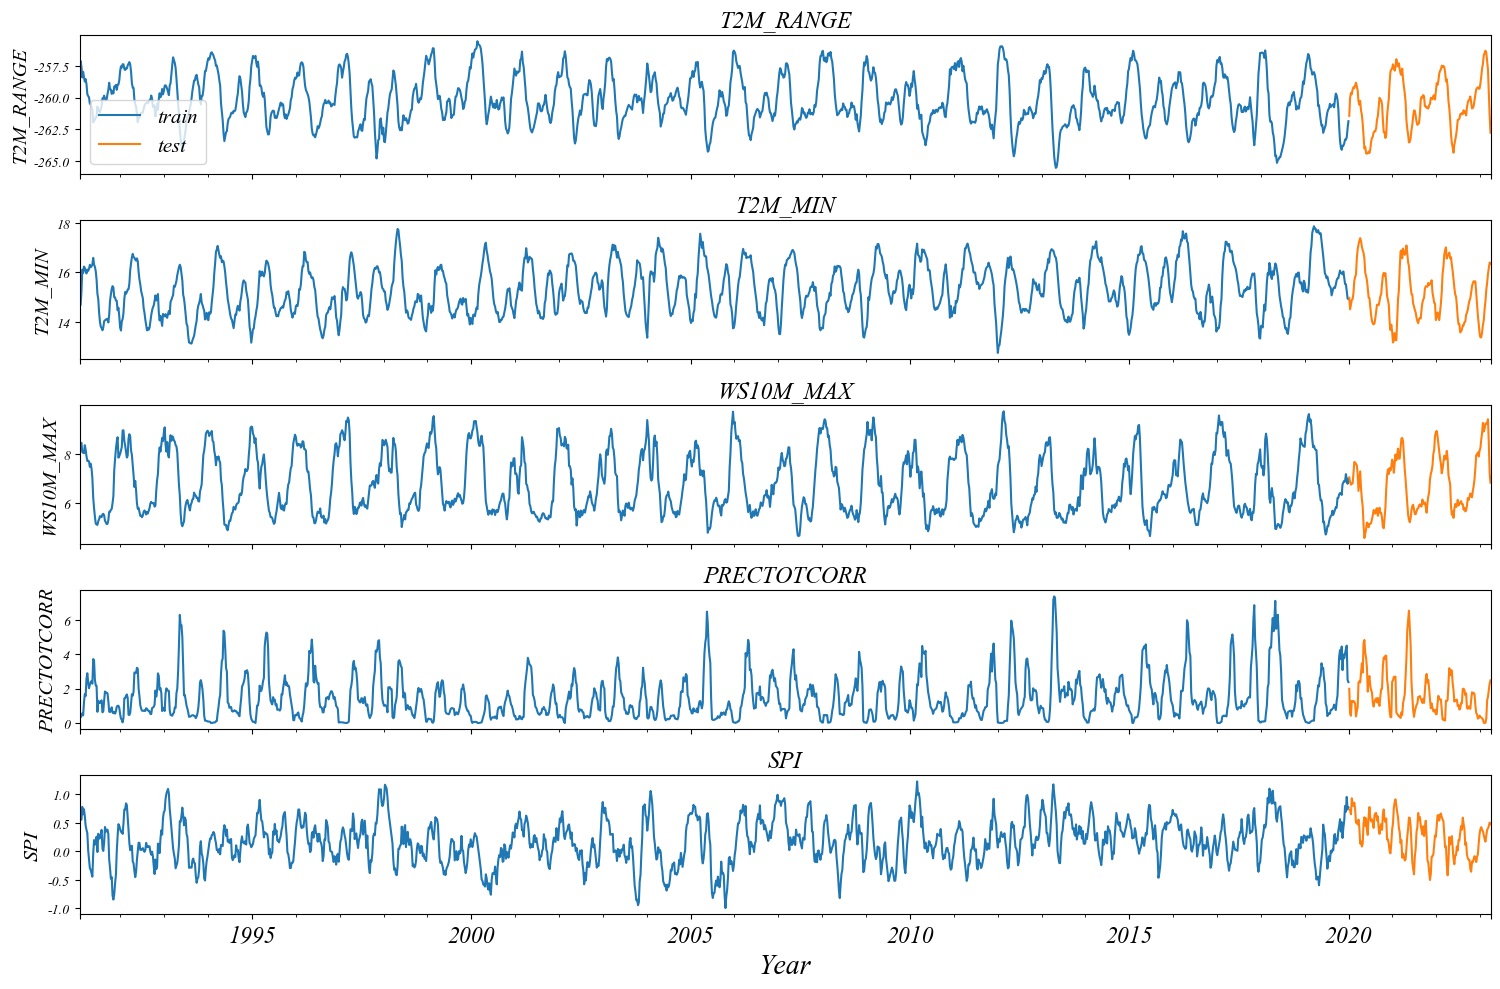

In [ ]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10), sharex=True)
font2 = {'family':'serif','color':'black','size':20}

data_train['T2M_RANGE'].plot(label='train', ax=axes[0])
data_test['T2M_RANGE'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('Year',fontdict = font2)
axes[0].set_ylabel('T2M_RANGE',fontsize=15)
axes[0].set_title('T2M_RANGE',fontsize=17)
axes[0].legend(fontsize=15)

data_train['T2M_MIN'].plot(label='train', ax=axes[1])
data_test['T2M_MIN'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('Year',fontdict = font2)
axes[1].set_ylabel('T2M_MIN',fontsize=15)
axes[1].set_title('T2M_MIN',fontsize=17)

data_train['WS10M_MAX'].plot(label='train', ax=axes[2])
data_test['WS10M_MAX'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('Year',fontdict = font2)
axes[2].set_ylabel('WS10M_MAX',fontsize=15)
axes[2].set_title('WS10M_MAX',fontsize=17)

data_train['PRECTOTCORR'].plot(label='train', ax=axes[3])
data_test['PRECTOTCORR'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('Year',fontdict = font2)
axes[3].set_ylabel('PRECTOTCORR', fontsize=15)
axes[3].set_title('PRECTOTCORR',fontsize=17)

data_train['SPI'].plot(label='train', ax=axes[4])
data_test['SPI'].plot(label='test', ax=axes[4])
axes[4].set_xlabel('Year',fontdict = font2)
axes[4].set_ylabel('SPI',fontsize=15)
axes[4].set_title('SPI',fontsize=17)
plt.xticks(fontsize=17)
fig.tight_layout()
plt.show();

### Dependent multi-series forecasting (Multivariate forecasting)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

#### XGB

> Multiseries Single-Step

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
from xgboost import XGBRegressor
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
# Grid search hyperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = XGBRegressor(random_state=123),
                 lags               = 4,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

# Lags used as predictors
lags_grid = [100, 200, 300]
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100,200],
    'max_depth': [5, 10, 15]
}
levels = ['T2M_RANGE', 'T2M_MIN', 'WS10M_MAX', 'PRECTOTCORR', 'SPI']

results = grid_search_forecaster_multiseries(
              forecaster          = forecaster,
              series              = data,
              exog                = None,
              levels              = levels,
              lags_grid           = lags_grid,
              param_grid          = param_grid,
              steps               = 1,
              metric              = 'mean_absolute_error',
              initial_train_size  = len(data_train),
              refit               = False,
              fixed_train_size    = True,
              return_best         = False,
              verbose             = False
          )

results

27 models compared for 5 level(s). Number of iterations: 27.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

,levels,lags,params,mean_absolute_error,max_depth,n_estimators
0,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.234079,5,50
1,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.235684,5,100
2,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.238849,5,200
9,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.245829,5,50
18,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",0.246107,5,50
10,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.248309,5,100
11,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.249514,5,200
19,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.250901,5,100
20,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 200}",0.256571,5,200
3,"[T2M_RANGE, T2M_MIN, WS10M_MAX, PRECTOTCORR, SPI]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",0.257204,10,50


In [ ]:
print(results_grid.lags[0])

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [ ]:
# Create and fit forecaster MultiVariate
# ==============================================================================
from xgboost import XGBRegressor
forecaster = ForecasterAutoregMultiSeries(
                 regressor          = XGBRegressor(max_depth= 5, n_estimators= 50),
                 lags               = 100,
                 transformer_series = StandardScaler(),
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None
             )

forecaster.fit(series=data_train)

In [ ]:

# Backtesting MultiVariate
# ==============================================================================
metrics_levels, backtest_predictions = backtesting_forecaster_multiseries(
                                           forecaster            = forecaster,
                                           series                = data,
                                           levels                = levels,
                                           steps                 = 1,
                                           metric                = ['mean_absolute_error','mean_squared_error', 'mean_absolute_percentage_error'],
                                           initial_train_size    = len(data_train),
                                           fixed_train_size      = True,
                                           gap                   = 0,
                                           allow_incomplete_fold = True,
                                           refit                 = False,
                                           verbose               = False,
                                           show_progress         = True
                                       )

print("Backtest metrics")
display(metrics_levels)
print("")
print("Backtest predictions")
backtest_predictions.head(4)

  0%|          | 0/169 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,T2M_RANGE,0.311561,0.163477,0.001196
1,T2M_MIN,0.153199,0.038093,0.010280
2,WS10M_MAX,0.201695,0.066863,0.029853
3,PRECTOTCORR,0.345527,0.234904,0.473879
4,SPI,0.110863,0.019052,1.632929



Backtest predictions


,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2020-01-07,-261.202742,14.875738,7.246968,1.740725,0.611732
2020-01-14,-260.593206,14.973650,7.374527,1.585769,0.651315
2020-01-21,-259.296648,14.747669,7.195351,0.480352,0.603401
2020-01-28,-258.888232,14.747256,7.090187,0.564976,0.612004


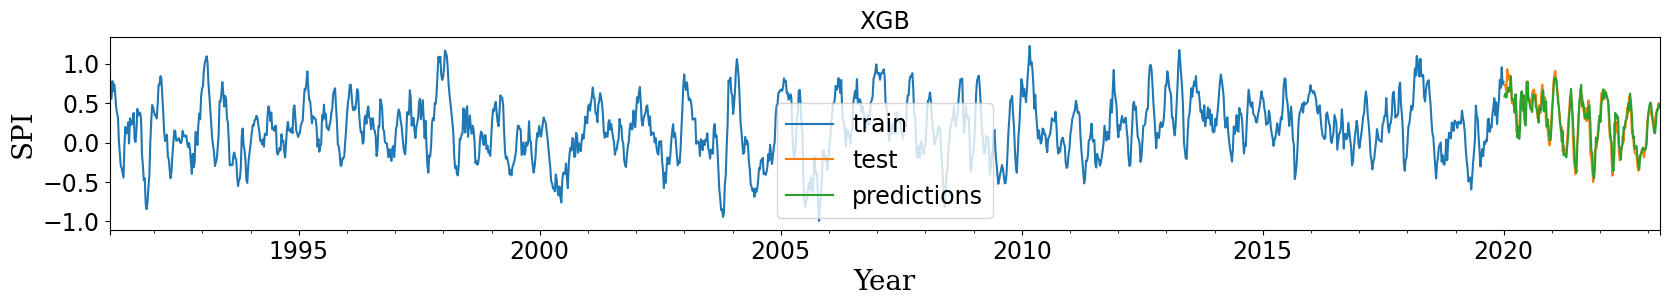

In [ ]:
# Plot
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(20, 2.5))
data_train['SPI'].plot(ax=ax, label='train')
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='XGB')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

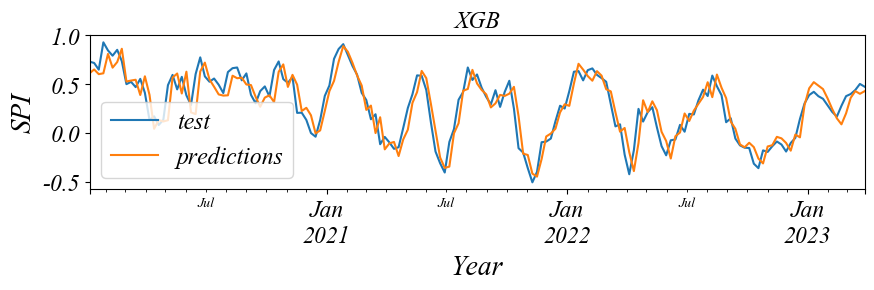

In [ ]:
# Plot predictions
# ==============================================================================
font1 = {'family':'Times New Roman','color':'blue','size':20}
font2 = {'family':'Times New Roman','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
data_test['SPI'].plot(ax=ax, label='test')
backtest_predictions['SPI'].plot(ax=ax, label='predictions')
plt.title(fontsize=17,label='XGB')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)
ax.legend(fontsize=17);

In [ ]:
# SPI
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['SPI'],backtest_predictions['SPI'])
mse = mean_squared_error(data_test['SPI'],backtest_predictions['SPI'])
r2 = r2_score(data_test['SPI'],backtest_predictions['SPI'])
rmse = math.sqrt(mean_squared_error(data_test['SPI'],backtest_predictions['SPI']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.11272766749201157
MSE is 0.01903841101794399
RMSE is 0.13797974857907225
R2 is 0.8158225132051987


In [ ]:
#T2M_RANGE
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
mse = mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
r2 = r2_score(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_RANGE'],backtest_predictions['T2M_RANGE']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.34258227259560475
MSE is 0.19524498904585166
RMSE is 0.44186535171458247
R2 is 0.9519289351198958


In [ ]:
#T2M_MIN
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
mse = mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
r2 = r2_score(data_test['T2M_MIN'],backtest_predictions['T2M_MIN'])
rmse = math.sqrt(mean_squared_error(data_test['T2M_MIN'],backtest_predictions['T2M_MIN']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.15921329138341161
MSE is 0.04220307267545719
RMSE is 0.2054338644806576
R2 is 0.9626262081612778


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
mse = mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
r2 = r2_score(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX'])
rmse = math.sqrt(mean_squared_error(data_test['WS10M_MAX'],backtest_predictions['WS10M_MAX']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.21619475729497492
MSE is 0.07061311612647925
RMSE is 0.26573128556208664
R2 is 0.9482913118337365


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
mse = mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
r2 = r2_score(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR'])
rmse = math.sqrt(mean_squared_error(data_test['PRECTOTCORR'],backtest_predictions['PRECTOTCORR']))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.3396785091616146
MSE is 0.2284700660713586
RMSE is 0.47798542453861353
R2 is 0.8453342606131592


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error
### Test data performance metrics
mae = mean_absolute_error(data_test,backtest_predictions)
mse = mean_squared_error(data_test,backtest_predictions)
r2 = r2_score(data_test,backtest_predictions)
rmse = math.sqrt(mean_squared_error(data_test,backtest_predictions))
print("The model performance for testing set:")
for i in range(38):
    print("-", end='')
print("\n")
print('MAE is {}'.format(mae))
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(rmse))
print('R2 is {}'.format(r2))

The model performance for testing set:
--------------------------------------

MAE is 0.2340792995855235
MSE is 0.11111393098741815
RMSE is 0.33333756312095725
R2 is 0.9048006457866536


In [ ]:
forecaster.fit(data)
forecaster

ForecasterAutoregMultiSeries 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53 

In [ ]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=300)
predictions.head()

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2023-04-04,-263.186461,16.385072,6.299167,2.474649,0.396559
2023-04-11,-263.329971,16.336375,5.932510,2.937824,0.390634
2023-04-18,-263.490373,16.342293,5.711328,3.092219,0.281758
2023-04-25,-263.544622,16.233506,5.573019,3.188707,0.174307
2023-05-02,-263.589429,16.135555,5.540639,3.261021,0.112319


In [ ]:
predictions.tail(3)

,T2M_RANGE,T2M_MIN,WS10M_MAX,PRECTOTCORR,SPI
2028-12-12,-258.740564,14.878518,8.089778,1.085611,0.307938
2028-12-19,-258.545916,14.760859,8.241542,1.076985,0.365272
2028-12-26,-258.146026,14.668160,8.318796,0.975873,0.460327


Text(0, 0.5, 'SPI')

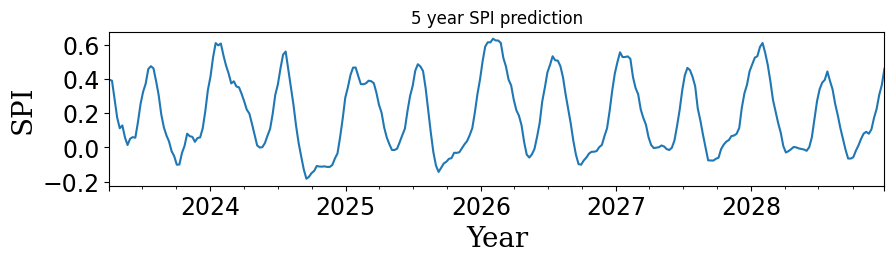

In [ ]:
# Plot predictions
# ==============================================================================
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'black','size':20}

fig, ax = plt.subplots(figsize=(10, 2))
predictions['SPI'].plot(ax=ax,title='5 year SPI prediction')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
ax.set_xlabel("Year", fontdict = font2)
ax.set_ylabel("SPI",fontdict = font2)